#  Install package

In [1]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai

# Import package

In [2]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

import base64

import pickle


# Define Solution class
Please run the following cell to define the functions

In [3]:
%load_ext autoreload
%autoreload 2

import LLM_Cat_Constants as constants
import helper

from LLM_Cat_kernel import Solution

# Demonstration Cases

## Input task and data desciption

In [4]:
# isReview = True
isReview = False

In [5]:
task_name ='Census_map'
TASK = r'''1. Create a thematic map to show the Census block group population. The location is Centre County, PA, USA. 
2. Carefuly design the map, make it beautiful and aesthetic appeal. The title, north arrow, scalebar, legend, and designer are needed. The designer is "LMM-Cat".
3. The map dimension is letter (8*11 inches) size.
'''

# 4. You need to design beautiful map elements such as color schemes.

DATA_LOCATIONS = [
    """Population file, GeoPackage format: D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg. Only one layer, no need to load it using a layer name. The population is in the 'totalpopulation' column. The map projection is Lambert Conformal Conic, EPSG 6564, StatePlane Pennsylvania South. The unit is meter.
    """
]

save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
# model = r'gpt-4-turbo-preview'
model = r'gpt-4-turbo'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional cartographer and programmer good at Python. You have worked on cartography more than 20 years, and know every detail and pitfall when visulizing spatial data and coding. You know well how to set up workflows for cartography tasks. You have significant experence on visualizing spatial data and graph theory. You are also experienced on generating map using Matplotlib, GeoPandas and other interative Python packages, such as Plotly.
 

Your task: Generate a graph (data structure) only, whose nodes are a series of consecutive steps to make a map, including visualize the data, add map element such as title, legend, scalebar, label, and annotaion:  
 1. Create a thematic map to show the Census block group population. The location is Centre County, PA, USA. 
2. Carefuly design the map, make it beautiful and aesthetic appeal. The title, north arrow, scalebar, legend, and designer are needed. The designer is "LLM-Cat".
3. The map dimension

## Get graph code from GPT API

In [6]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Nodes and Edges
# Data Nodes
G.add_node("population_gpkg_url", node_type="data", data_path="D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg", description="URL to Centre County Census Block Group GeoPackage")
G.add_node("population_gdf", node_type="data", description="GeoDataFrame after loading population GeoPackage")
G.add_node("projected_population_gdf", node_type="data", description="Projected GeoDataFrame with correct EPSG for visualization")

# Operation Nodes
G.add_node("load_population", node_type="operation", description="Load population data from GeoPackage")
G.add_node("project_population_data", node_type="operation", description="Project the population data to the appropriate map projection")

# Edges for Data Loading and Projection
G.add_edge("population_gpkg_url", "load_population")
G.add_edge("load_population", "population_gdf")
G.add_edge("population_gdf", "project_population_data")
G.add_edge("project_population_data", "projected_population_gdf")

# Nodes and Edges for Map Elements
G.add_node("map_title", node_type="data", description="Map title node")
G.add_node("add_title", node_type="operation", description="Operation to add title to map")
G.add_node("north_arrow", node_type="data", description="North arrow node")
G.add_node("add_north_arrow", node_type="operation", description="Operation to add north arrow to map")
G.add_node("scale_bar", node_type="data", description="Scale bar node")
G.add_node("add_scale_bar", node_type="operation", description="Operation to add scale bar to map")
G.add_node("legend", node_type="data", description="Legend node")
G.add_node("add_legend", node_type="operation", description="Operation to add legend to map")
G.add_node("map_designer", node_type="data", description="Map designer node: LLM-Cat")
G.add_node("final_map", node_type="data", description="The final map node, containing all elements and ready for output")

# Edges for Map Elements
G.add_edge("projected_population_gdf", "add_title")
G.add_edge("add_title", "map_title")
G.add_edge("map_title", "add_north_arrow")
G.add_edge("add_north_arrow", "north_arrow")
G.add_edge("north_arrow", "add_scale_bar")
G.add_edge("add_scale_bar", "scale_bar")
G.add_edge("scale_bar", "add_legend")
G.add_edge("add_legend", "legend")
G.add_edge("legend", "map_designer")
G.add_edge("map_designer", "final_map")

# Saving the network
nx.write_graphml(G, "D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\Census_map\\Census_map.graphml")

## Execute code to generate the solution graph

In [7]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\Census_map.html


## Generate prompts and code for operations (functions)

In [8]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Description: Load population data from GeoPackage
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf
import geopandas as gpd

def project_population_data(population_gdf):
    # Description: Project the population data to the appropriate map projection
    projected_population_gdf = population_gdf.to_crs(epsg=6564)  # Lambert Conformal Conic, StatePlane Pennsylvania South
    return projected_population_gdf
import matplotlib.pyplot as plt

def add_title(projected_population_gdf):
    # Description: Operation to add title to map
    fig, ax = plt.subplots(figsize=(8, 11))  # Letter size 8*11 inches
    projected_population_gdf.plot(ax=ax)
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=15, fontweight='bold')
    map_title = ax.get_title()
    plt.close(fig)
    return map_title
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def add_north_arrow(map_title):
    # Description: Operation to add north arrow to map
    fig, ax = plt.subplots()
    ax.set_title(map_title)
    
    # Create an arrow
    arrow = FancyArrowPatch((0.1, 0.1), (0.1, 0.2),
                            arrowstyle='->,head_width=0.05,head_length=0.1',
                            color='black',
                            transform=ax.transAxes)
    
    ax.add_patch(arrow)
    # Annotations for North since it always points to the top in a typical map view
    ax.annotate('N', xy=(0.1, 0.2), xytext=(0.1, 0.22),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center', transform=ax.transAxes)

    plt.close(fig)
    north_arrow = arrow, ax.get_children()[-1]  # Return both the arrow and the 'N' annotation text

    return north_arrow
from matplotlib_scalebar.scalebar import ScaleBar

def add_scale_bar(north_arrow):
    # Description: Operation to add scale bar to map
    fig, ax = plt.subplots()
    ax.add_artist(north_arrow[0])  # Add the north arrow previously defined in another function
    ax.text(north_arrow[1].get_position()[0], north_arrow[1].get_position()[1] + 0.05,
            north_arrow[1].get_text(), transform=ax.transAxes, ha='center')  # Adjust position relative to north arrow

    # Adding a scale bar
    scale_bar = ScaleBar(1, location='lower left', units='m', dimension='si-length', scale_loc='bottom', length_fraction=0.25)
    ax.add_artist(scale_bar)
    
    plt.close(fig)
    return scale_bar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def add_legend(scale_bar):
    # Description: Operation to add legend to map
    fig, ax = plt.subplots()
    ax.add_artist(scale_bar)  # Use the scale bar from the previous function

    # Defining a simple color map for population densities
    cmap = plt.cm.viridis  # Using viridis colormap
    norm = mcolors.Normalize(vmin=0, vmax=1000)  # Assuming population range from 0 to 1000 for demonstration

    # Creating a colorbar as the legend for the population density
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Population Density (per block group)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    plt.close(fig)
    # Return the colorbar object, which acts as the map legend
    return cbar

## Generate prompts and code for assembly program

In [9]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Load population data from GeoPackage
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_population_data(population_gdf):
    # Project the population data to the appropriate map projection
    projected_population_gdf = population_gdf.to_crs(epsg=6564)
    return projected_population_gdf

def add_title(projected_population_gdf):
    # Operation to add title to map
    fig, ax = plt.subplots(figsize=(8, 11))  # Letter size 8*11 inches
    projected_population_gdf.plot(ax=ax, column='totalpopulation', cmap='viridis', legend=True, legend_kwds={'label': "Population Density (per block group)", 'orientation': "horizontal"})
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=15, fontweight='bold')
    return fig, ax

def add_north_arrow(fig, ax):
    # Operation to add north arrow to map
    arrow = FancyArrowPatch((0.1, 0.1), (0.1, 0.2),
                            arrowstyle='->,head_width=0.05,head_length=0.1',
                            color='black',
                            transform=ax.transAxes)
    
    ax.add_patch(arrow)
    ax.annotate('N', xy=(0.1, 0.2), xytext=(0.1, 0.25),
                textcoords='axes fraction', ha='center', fontstyle='italic')

    return fig, ax

def add_scale_bar(fig, ax):
    # Operation to add scale bar to map
    scale_bar = ScaleBar(1, location='lower left', units='m', scale_loc='bottom', length_fraction=0.25)
    ax.add_artist(scale_bar)
    
    return fig, ax

def add_designer_signature(fig, ax):
    # Add designer signature
    ax.text(0.95, 0.01, 'Map design by LLM-Cat', verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='grey', fontsize=7)
    return fig, ax

def save_map(fig):
    # Save the generated map to a file
    fig.savefig('output_map.png', dpi=100)
    plt.close(fig)

def assemble_solution():
    # Assemble all functions to generate the thematic map
    pop_gdf = load_population()
    projected_pop_gdf = project_population_data(pop_gdf)
    fig, ax = add_title(projected_pop_gdf)
    fig, ax = add_north_arrow(fig, ax)
    fig, ax = add_scale_bar(fig, ax)
    fig, ax = add_designer_signature(fig, ax)
    save_map(fig)

assemble_solution()

## Execute assembly code

In [10]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))
solution.all_code = all_code

In [11]:
all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

solution.all_code = all_code

image_path = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\output_map.png"
from PIL import Image
import matplotlib.pyplot as plt

def show_map():
    image = Image.open(image_path)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_axis_off()
    plt.imshow(image)
    
show_map()   
display(Code(all_code, language='python'))



-------------- Running code (trial # 1/10) --------------




--------------- Done ---------------




import geopandas as gpd

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Description: Load population data from GeoPackage
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf
import geopandas as gpd

def project_population_data(population_gdf):
    # Description: Project the population data to the appropriate map projection
    projected_population_gdf = population_gdf.to_crs(epsg=6564)  # Lambert Conformal Conic, StatePlane Pennsylvania South
    return projected_population_gdf
import matplotlib.pyplot as plt

def add_title(projected_population_gdf):
    # Description: Operation to add title to map
    fig, ax = plt.subplots(figsize=(8, 11))  # Letter size 8*11 inches
    projected_population_gdf.plot(ax=ax)
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=15, fontweight='bold')
    map_title = ax.get_title()
    plt.close(fig)
    return map_title
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def add_north_arrow(map_title):
    # Description: Operation to add north arrow to map
    fig, ax = plt.subplots()
    ax.set_title(map_title)
    
    # Create an arrow
    arrow = FancyArrowPatch((0.1, 0.1), (0.1, 0.2),
                            arrowstyle='->,head_width=0.05,head_length=0.1',
                            color='black',
                            transform=ax.transAxes)
    
    ax.add_patch(arrow)
    # Annotations for North since it always points to the top in a typical map view
    ax.annotate('N', xy=(0.1, 0.2), xytext=(0.1, 0.22),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center', transform=ax.transAxes)

    plt.close(fig)
    north_arrow = arrow, ax.get_children()[-1]  # Return both the arrow and the 'N' annotation text

    return north_arrow
from matplotlib_scalebar.scalebar import ScaleBar

def add_scale_bar(north_arrow):
    # Description: Operation to add scale bar to map
    fig, ax = plt.subplots()
    ax.add_artist(north_arrow[0])  # Add the north arrow previously defined in another function
    ax.text(north_arrow[1].get_position()[0], north_arrow[1].get_position()[1] + 0.05,
            north_arrow[1].get_text(), transform=ax.transAxes, ha='center')  # Adjust position relative to north arrow

    # Adding a scale bar
    scale_bar = ScaleBar(1, location='lower left', units='m', dimension='si-length', scale_loc='bottom', length_fraction=0.25)
    ax.add_artist(scale_bar)
    
    plt.close(fig)
    return scale_bar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def add_legend(scale_bar):
    # Description: Operation to add legend to map
    fig, ax = plt.subplots()
    ax.add_artist(scale_bar)  # Use the scale bar from the previous function

    # Defining a simple color map for population densities
    cmap = plt.cm.viridis  # Using viridis colormap
    norm = mcolors.Normalize(vmin=0, vmax=1000)  # Assuming population range from 0 to 1000 for demonstration

    # Creating a colorbar as the legend for the population density
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Population Density (per block group)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    plt.close(fig)
    # Return the colorbar object, which acts as the map legend
    return cbar
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    # Load population data from GeoPackage
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_pop

In [12]:
# display(Code(all_code, language='python'))

# Beautify map

In [13]:
print(solution.get_review_prompt())

Your role: A professional cartographer. You have worked on cartography more than 20 years, and know how to design an aesthietic appeal map. Your current job is to review the map generated by AI. You need to point out the issues of the given map in detail, so that the AI can improve the map later. Note that AI makes the map via generated code, so your comments should be suitable for improvements by code. The requirements of the map are also provided.
 
Your task: Observe the given map carefully using the viewpoint of an experienced cartographer. 

Requirements: 
1. Elaborate the issues, then provide the specific and actionable improvements, such as 'move the legend to the up-left to void obscuring'. If you think there is no issue, no need to mention.
2. Whether the title semantically meet the data and map requirement.
3. Whether the fonts and font sizes are suitable and hierachical.
4. Wheter the map is in the center.
5. Whether the legend or colorbar use the some color scheme.
6. Wheth

## Map review

1. The title font size is too small, needs to be enlarged to enhance readability.
2. The map is not centered vertically within the image frame; adjust the vertical alignment for better visualization.
3. Both the scale bar and the color bar should have more distinct colors from their labels to enhance readability.
4. The position of the scale bar at the bottom left overlays with the map bounds, which could obscure details; move it to a location that does not overlay with important map data.
5. The map legend (color bar) uses a color scheme appropriate for displaying population density variations.
6. The size of the scale bar is appropriate, but its positioning could be improved as noted in point 4.
7. The scale bar measurement does not specify units (e.g., km); add the unit of measurement for clarity.
8. The map elements are well spaced and do not create a cluttered appearance.
9. There are no redundant map elements. All elements contribute to the map's utility.




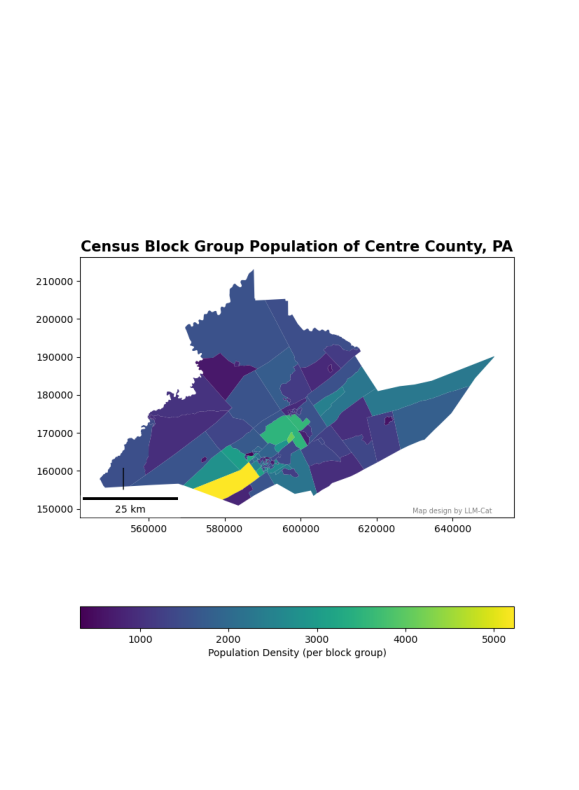

In [14]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\output_map.png"

# Getting the base64 string
base64_image = encode_image(image_path)

from PIL import Image
import matplotlib.pyplot as plt

def show_map():
    image = Image.open(image_path)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_axis_off()
    plt.imshow(image)


solution.ask_LLM_to_review_map(map_base64=base64_image, model='gpt-4-turbo')

show_map()

## Beautify 1

Revising the map, trial 1 / 1
**Current map issues:**
1. **Title Font Size:** The current font size of the title at 15 is slightly smaller considering its importance. It can be increased for better visibility and prominence.
2. **Color Gradient of the Map:** The map uses a `viridis` colormap which is generally good for data visualization, but we might consider adjusting it to enhance visual appeal and interpretability.
3. **Legend Positioning and Detailing:** The legend is currently at the bottom and horizontal, which might make it less intuitive for quick reference.
4. **Scale Bar Clarity:** The scale bar's font size and positioning can be improved to ensure that it is immediately understandable.
5. **North Arrow Style and Placement:** The north arrow, while present, is minimal and could be made more prominent.
6. **Map Borders and Margins:** The map could benefit from better-defined borders and margins to neatly frame the information.
7. **Text Overlap:** The designer signature is pl

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_population_data(population_gdf):
    projected_population_gdf = population_gdf.to_crs(epsg=6564)
    return projected_population_gdf

def add_title(projected_population_gdf):
    fig, ax = plt.subplots(figsize=(8, 11))
    projected_population_gdf.plot(ax=ax, column='totalpopulation', cmap='coolwarm', legend=True, legend_kwds={'label': "Population Density (per block group)", 'orientation': "horizontal"})
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=24, fontweight='bold', color='navy')
    return fig, ax

def add_north_arrow(fig, ax):
    arrow = FancyArrowPatch((0.95, 0.1), (0.95, 0.2), arrowstyle='->,head_width=1,head_length=2', color='gray', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.annotate('N', xy=(0.95, 0.2), xytext=(0.95, 0.22), textcoords='axes fraction', ha='center', va='bottom', fontsize=10, color='gray')
    return fig, ax

def add_scale_bar(fig, ax):
    scale_bar = ScaleBar(1, location='lower right', units='m', scale_loc='bottom', length_fraction=0.1, height_fraction=0.005, font_properties={'size':10})
    ax.add_artist(scale_bar)
    return fig, ax

def add_legend(fig, ax, projected_population_gdf):
    cax = fig.add_axes([0.85, 0.1, 0.03, 0.8])  # Position of the legend
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=projected_population_gdf['totalpopulation'].min(), vmax=projected_population_gdf['totalpopulation'].max()))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Population Density (per block group)', fontsize=12)
    return fig, ax

def add_designer_signature(fig, ax):
    ax.text(0.95, 0.01, 'Map design by LLM-Cat', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=8)
    return fig, ax

def save_map(fig):
    fig.savefig('output_map.png', dpi=100)
    plt.close(fig)

def assemble_solution():
    pop_gdf = load_population()
    projected_pop_gdf = project_population_data(pop_gdf)
    fig, ax = add_title(projected_pop_gdf)
    fig, ax = add_north_arrow(fig, ax)
    fig, ax = add_scale_bar(fig, ax)
    fig, ax = add_legend(fig, ax, projected_pop_gdf)
    fig, ax = add_designer_signature(fig, ax)
    save_map(fig)

assemble_solution()

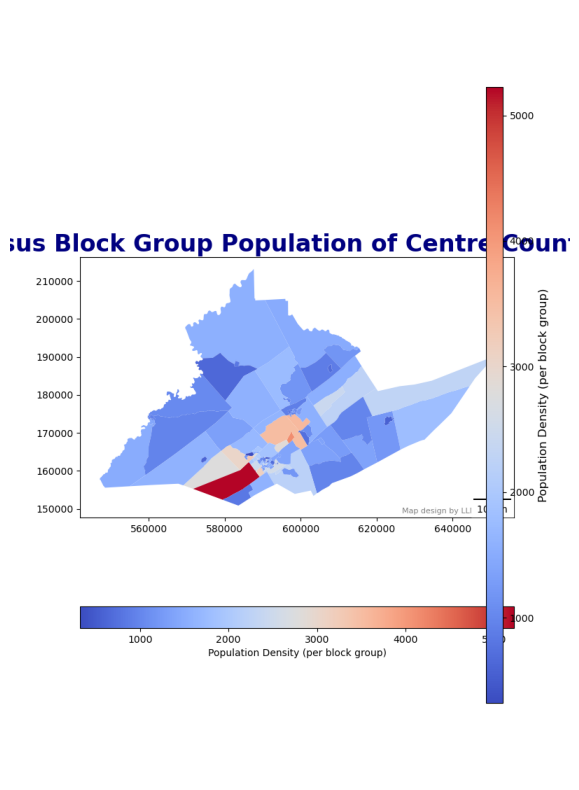

In [15]:
# solution.get_beautify_text_prompt(solution.all_code)

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
 
 
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

  
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 2

Revising the map, trial 1 / 1
### Current Map Issues and Proposed Improvements:

1. **Title and Text Legibility**: The title font is appropriately sized but the contrast could be enhanced for better legibility. The designer signature is quite small and may be hard to read.
2. **North Arrow Placement**: The north arrow is tucked in the corner, which might make it less noticeable. Its style could also be more distinct.
3. **Scale Bar Appearance**: The scale bar, currently in meters (appropriate for small areas), is small and minimally styled. It lacks prominence and clarity.
4. **Legend**: While the legend effectively shows population density, it is overly tall relative to the map size. The font size for the population counts is also quite small and could be more prominent for better readability.
5. **Color Harmony and Contrast**: The color scheme of 'coolwarm' is suitable for showing variation but could be adjusted for better visual appeal and clarity.
6. **Map Clutter and Balance**: Th

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_population_data(population_gdf):
    projected_population_gdf = population_gdf.to_crs(epsg=6564)
    return projected_population_gdf

def add_title(projected_population_gdf):
    fig, ax = plt.subplots(figsize=(8, 11))
    projected_population_gdf.plot(ax=ax, column='totalpopulation', cmap='viridis', legend=True, legend_kwds={'label': "Population Density (per block group)", 'orientation': "horizontal"})
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=24, fontweight='bold', color='navy')
    return fig, ax

def add_north_arrow(fig, ax):
    arrow = FancyArrowPatch((0.05, 0.05), (0.05, 0.15), arrowstyle='->,head_width=1,head_length=2', color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.annotate('N', xy=(0.05, 0.15), xytext=(0.05, 0.17), textcoords='axes fraction', ha='center', va='bottom', fontsize=12, color='black')
    return fig, ax

def add_scale_bar(fig, ax):
    scale_bar = ScaleBar(1, location='lower left', units='m', scale_loc='bottom', length_fraction=0.1, height_fraction=0.005, font_properties={'size':12, 'weight':'bold'})
    ax.add_artist(scale_bar)
    return fig, ax

def add_legend(fig, ax, projected_population_gdf):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=projected_population_gdf['totalpopulation'].min(), vmax=projected_population_gdf['totalpopulation'].max()))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Population Density (per block group)', fontsize=12)
    return fig, ax

def add_designer_signature(fig, ax):
    ax.text(0.95, 0.01, 'Map design by LLM-Cat', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=10)
    return fig, ax

def save_map(fig):
    fig.savefig('output_map.png', dpi=100)
    plt.close(fig)

def assemble_solution():
    pop_gdf = load_population()
    projected_pop_gdf = project_population_data(pop_gdf)
    fig, ax = add_title(projected_pop_gdf)
    fig, ax = add_north_arrow(fig, ax)
    fig, ax = add_scale_bar(fig, ax)
    fig, ax = add_legend(fig, ax, projected_pop_gdf)
    fig, ax = add_designer_signature(fig, ax)
    save_map(fig)

assemble_solution()

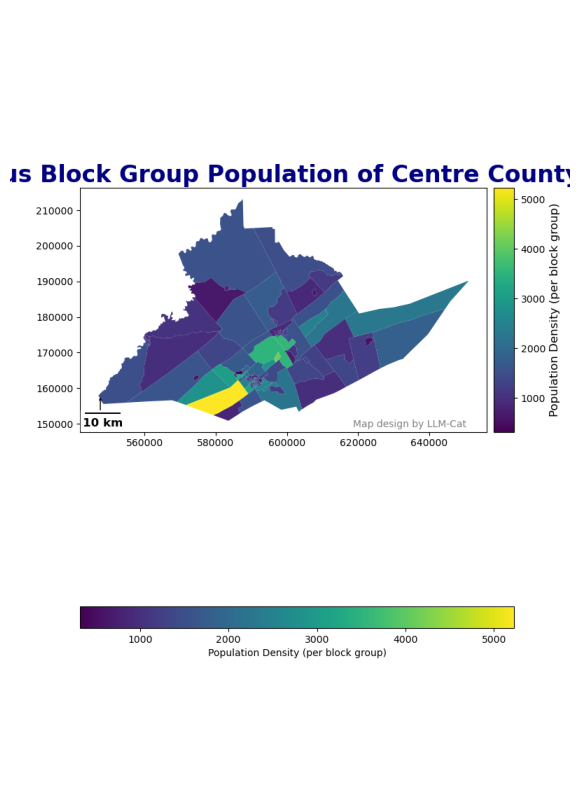

In [16]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()


show_map()
display(Code(all_code, language='python'))



## Beautify 3

Revising the map, trial 1 / 1
Based on my examination of the currently generated map and the given Python code, I have identified several areas for improvement to enhance clarity, readability, and aesthetic appeal. Below are the key issues and the proposed solutions:

### Current Map Issues:
1. **Font Sizes and Styles**: Title needs emphasis and hierarchy is not clear between map elements. Legibility can be compromised on smaller screens or prints.
2. **Legend Clarity and Placement**: The legend uses a horizontal orientation at the bottom, which might be blocking some of the map data or making it cluttered.
3. **North Arrow and Scale Bar**: The north arrow is not prominently visible, and the scale bar lacks clear demarcation and unit display.
4. **Color Scheme**: The current color palette ('viridis') is functional but could be enhanced for better visual impact and to make it more intuitive for map readers.
5. **Map Grids and Basemap**: Adding a subtle basemap or grids could enhance the

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_population_data(population_gdf):
    projected_population_gdf = population_gdf.to_crs(epsg=6564)  # No change needed, correct projection
    return projected_population_gdf

def add_title(fig, ax):
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=24, fontweight='bold', color='navy', style='italic')
    return fig, ax

def add_north_arrow(fig, ax):
    arrow = FancyArrowPatch((0.95, 0.05), (0.95, 0.10), arrowstyle='->,head_width=1,head_length=2', color='black', transform=ax.transAxes, lw=2)
    ax.add_patch(arrow)
    ax.annotate('N', xy=(0.95, 0.06), xycoords='axes fraction', ha='center', va='bottom', fontsize=16, color='black')
    return fig, ax

def add_scale_bar(fig, ax):
    scale_bar = ScaleBar(1, location='lower right', units='m', scale_loc='bottom', length_fraction=0.1, font_properties={'size':14, 'weight':'bold'})
    ax.add_artist(scale_bar)
    return fig, ax

def add_legend(fig, ax, projected_population_gdf):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=projected_population_gdf['totalpopulation'].min(), vmax=projected_population_gdf['totalpopulation'].max()))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Population Density (per block group)', fontsize=14)
    return fig, ax

def add_designer_signature(fig, ax):
    ax.text(0.01, 0.01, 'Map design by LLM-Cat', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='grey', fontsize=12)
    return fig, ax

def save_map(fig):
    fig.savefig('output_map.png', dpi=100)
    plt.close(fig)

def assemble_solution():
    pop_gdf = load_population()
    projected_pop_gdf = project_population_data(pop_gdf)
    fig, ax = plt.subplots(figsize=(8, 11))
    projected_pop_gdf.plot(ax=ax, column='totalpopulation', cmap='coolwarm', legend=False)
    fig, ax = add_title(fig, ax)
    fig, ax = add_north_arrow(fig, ax)
    fig, ax = add_scale_bar(fig, ax)
    fig, ax = add_legend(fig, ax, projected_pop_gdf)
    fig, ax = add_designer_signature(fig, ax)
    save_map(fig)

assemble_solution()

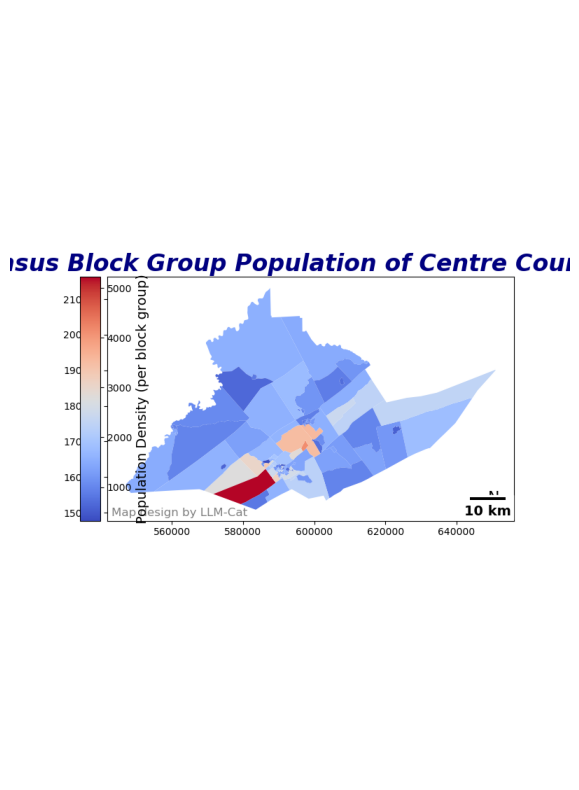

In [18]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 4

Revising the map, trial 1 / 1
### Current Map Issues:
1. **Title:** The title font is appropriate in size but could use a slightly less obtrusive style (i.e., remove the italic).
2. **North Arrow:** The north arrow placement is fine, but could be made more subtle in line thickness and color.
3. **Legend Placement:** The legend is positioned on the left which is unconventional. It is usually more effective on the right or bottom as it doesn't interfere with the main map view upon first glance.
4. **Scale Bar:** The font on the scale bar is bold, which is unnecessary and clutters the visual; it should also be a bit more prominent in size relative to the map dimensions.
5. **Colorbar Scale:** The color scale is divergent (coolwarm), which may not be optimal for representing population density where a sequential palette would make more intuitive sense.
6. **Text Overlapping:** The designer's signature overlaps partially with the scale bar, causing a cluttered look in the bottom left corner

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_population_data(population_gdf):
    projected_population_gdf = population_gdf.to_crs(epsg=6564)  # No change needed, correct projection
    return projected_population_gdf

def add_title(fig, ax):
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=25, fontweight='normal', color='navy', style='normal')
    return fig, ax

def add_north_arrow(fig, ax):
    arrow = FancyArrowPatch((0.95, 0.05), (0.95, 0.10), arrowstyle='->,head_width=1,head_length=2', color='gray', transform=ax.transAxes, lw=1)
    ax.add_patch(arrow)
    ax.annotate('N', xy=(0.95, 0.06), xycoords='axes fraction', ha='center', va='bottom', fontsize=12, color='gray')
    return fig, ax

def add_scale_bar(fig, ax):
    scale_bar = ScaleBar(1, location='lower right', units='m', scale_loc='bottom', length_fraction=0.12, font_properties={'size': 12, 'weight':'normal'})
    ax.add_artist(scale_bar)
    return fig, ax

def add_legend(fig, ax, projected_population_gdf):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=projected_population_gdf['totalpopulation'].min(), vmax=projected_population_gdf['totalpopulation'].max()))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Population Density (per block group)', fontsize=12)
    return fig, ax

def add_designer_signature(fig, ax):
    ax.text(0.01, 0.02, 'Map design by LLM-Cat', verticalalignment='bottom', horizontalalignment='left', transform=ax.transAxes, color='grey', fontsize=11)
    return fig, ax

def save_map(fig):
    fig.savefig('output_map.png', dpi=100)
    plt.close(fig)

def assemble_solution():
    pop_gdf = load_population()
    projected_pop_gdf = project_population_data(pop_gdf)
    fig, ax = plt.subplots(figsize=(8, 11))
    projected_pop_gdf.plot(ax=ax, column='totalpopulation', cmap='YlOrRd', legend=False)
    fig, ax = add_title(fig, ax)
    fig, ax = add_north_arrow(fig, ax)
    fig, ax = add_scale_bar(fig, ax)
    fig, ax = add_legend(fig, ax, projected_pop_gdf)
    fig, ax = add_designer_signature(fig, ax)
    save_map(fig)

assemble_solution()

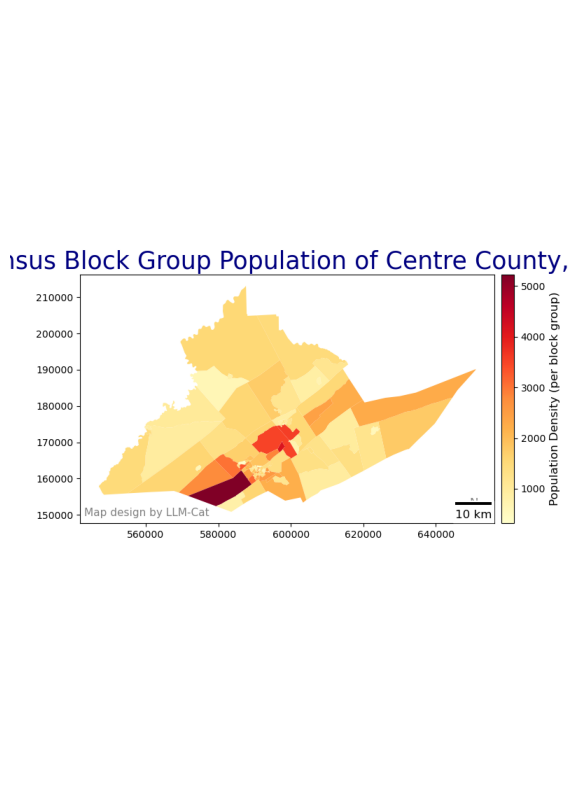

In [19]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 5

Revising the map, trial 1 / 1
Current map issues:
1. The title lacks contrast with the background color and might benefit from a more distinctive style to help highlight its importance.
2. The color bar, while useful, dominates the right side of the map excessively due to its width. Reducing its width could help balance the overall map composition.
3. The north arrow and the scale bar are somewhat understated and could be overlooked by users. Enhancing these elements would improve the map’s functionality.
4. The designer’s signature is in a default font that lacks distinctiveness. A more styled font could better integrate the signature into the map's aesthetic.

Improvement:
1. Modify the title style to include a stronger font weight and adjust the color for better visibility.
2. Adjust the width of the color bar to make it more proportional to the layout of the map.
3. Redesign the north arrow to make it more prominent and adjust the scale bar to be more visible.
4. Style the designer

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_population(population_gpkg_url='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg'):
    population_gdf = gpd.read_file(population_gpkg_url)
    return population_gdf

def project_population_data(population_gdf):
    projected_population_gdf = population_gdf.to_crs(epsg=6564)  # No change needed, correct projection
    return projected_population_gdf

def add_title(fig, ax):
    ax.set_title("Census Block Group Population of Centre County, PA", fontsize=25, fontweight='bold', color='darkblue', style='italic')
    return fig, ax

def add_north_arrow(fig, ax):
    arrow = FancyArrowPatch((0.05, 0.05), (0.05, 0.10), arrowstyle='->,head_width=2,head_length=4', color='black', transform=ax.transAxes, lw=1.5)
    ax.add_patch(arrow)
    ax.annotate('N', xy=(0.05, 0.12), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color='black')
    return fig, ax

def add_scale_bar(fig, ax):
    scale_bar = ScaleBar(1, location='lower left', units='km', scale_loc='bottom', length_fraction=0.25, font_properties={'size': 12, 'weight':'bold'})
    ax.add_artist(scale_bar)
    return fig, ax

def add_legend(fig, ax, projected_population_gdf):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=projected_population_gdf['totalpopulation'].min(), vmax=projected_population_gdf['totalpopulation'].max()))
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label('Population Density (per block group)', fontsize=12, fontweight='bold')
    return fig, ax

def add_designer_signature(fig, ax):
    ax.text(0.01, 0.98, 'Map design by LLM-Cat', verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, color='black', fontsize=12, style='italic')
    return fig, ax

def save_map(fig):
    fig.savefig('output_map.png', dpi=100)
    plt.close(fig)

def assemble_solution():
    pop_gdf = load_population()
    projected_pop_gdf = project_population_data(pop_gdf)
    fig, ax = plt.subplots(figsize=(8, 11))
    projected_pop_gdf.plot(ax=ax, column='totalpopulation', cmap='YlOrBr', legend=False)
    fig, ax = add_title(fig, ax)
    fig, ax = add_north_arrow(fig, ax)
    fig, ax = add_scale_bar(fig, ax)
    fig, ax = add_legend(fig, ax, projected_pop_gdf)
    fig, ax = add_designer_signature(fig, ax)
    save_map(fig)

assemble_solution()

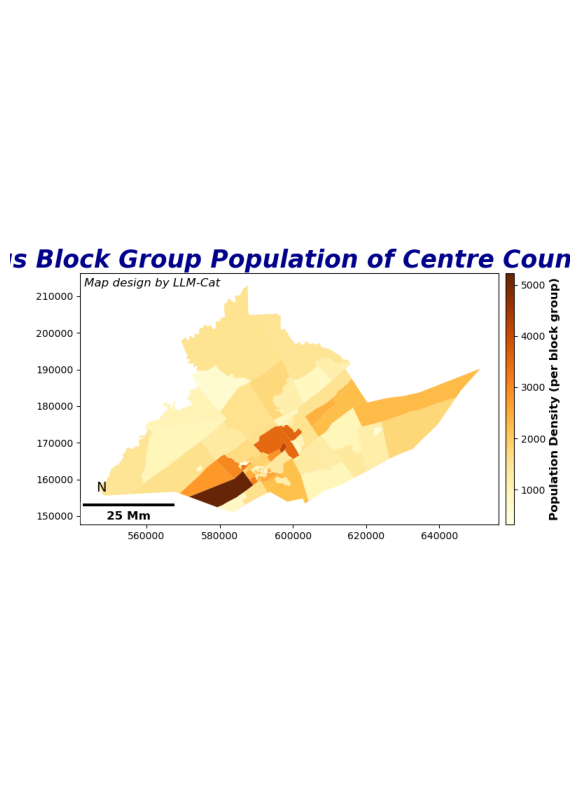

In [20]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

In [ ]:
STOP

# Tools


## load a solution

In [ ]:

# import pickle

# saved_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\Census_map\Census_map.pkl"
# file = open(saved_fname, 'rb')

# solution = pickle.load(file)

# file.close()
# print(solution.task)